Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.0_gsyn=1.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.002_Gc=0.7_ggap=1.0_gsyn=1.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.875_gsyn=1.5
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=1.184
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=1.263


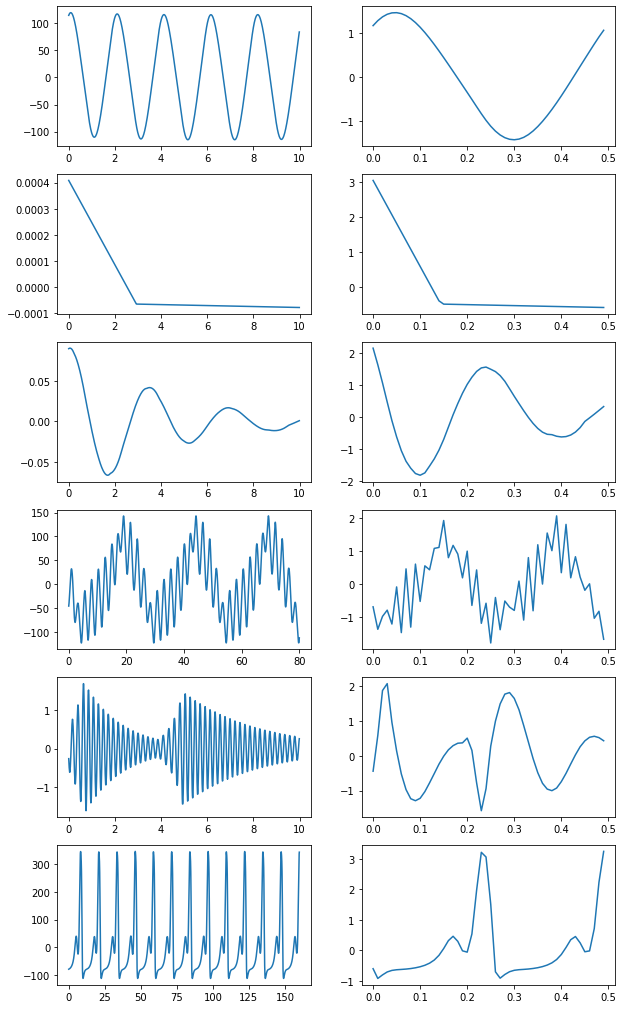

In [57]:
import numpy as np
import pandas as pd
import time
from neural_model import NeuralModel
from simulation_functions import *
from sklearn.decomposition import PCA
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from tslearn.utils import to_time_series
from util.analysis_util import *
from util.neuron_metadata import *
from util.plot_util import *

neuron_metadata_collection = NeuronMetadataCollection.load_from_chem_json('data/chem.json')
last_n_percent = 0.50

def get_dom_mode(ggap, gsyn, C = 0.015, Gc = 0.1):
  all_dynamics = simulate_until_stable(
    C = C,
    Gc = Gc,
    ggap = ggap,
    gsyn = gsyn)
  n = all_dynamics.shape[0]
  last_dynamics = all_dynamics[-int(last_n_percent * n):,:]
  pca = PCA(n_components = 1)
  # Perform mean-centering before PCA
  X = last_dynamics - last_dynamics.mean(axis= 0)
  projected_X = pca.fit_transform(last_dynamics)
  return projected_X[:,0]

def preprocess_ts(ts):
  # Scale to mean 0 variance 1. We want similar looking-graphs, no matter the amplitude,
  # to be grouped together
  fft_period = get_period(ts)
  # Times 100 because the period is in seconds, but our array timescale is 0.01s for each index.
  # Times 2 because we want to see multiple periods to distinguish between focus and stable oscillation.
  ts = ts[-int(fft_period) * 100 * 2:]
  ts = TimeSeriesScalerMeanVariance().fit_transform(ts)
  # Make time series shorter for faster processing.
  # Disadvantage is that we will lose the smoothness vs sharpness info.
  ts = TimeSeriesResampler(sz=50).fit_transform(ts)
  ts = ts.reshape(-1)
  return ts

def plot_ts(ax, ts):
  times = np.arange(0, ts.shape[0] * 0.01 , 0.01)
  ax.plot(times, ts)
  
ts_simple_oscillation = get_dom_mode(ggap = 1.0, gsyn = 1.0)
ts_stable_node = get_dom_mode(ggap = 0.0, gsyn = 0.0)
ts_stable_focus = get_dom_mode(C = 0.002, Gc = 0.7, ggap = 1.0, gsyn = 1.0)
ts_nested_oscillation_mean_shift = get_dom_mode(ggap = 0.875, gsyn = 1.5)
ts_nested_oscillation_amplitude_shift = get_dom_mode(ggap = 0.0789, gsyn = 1.1842)
ts_spike = get_dom_mode(ggap = 0.1579, gsyn = 1.2632)

ts_list = \
  [
    ts_simple_oscillation,
    ts_stable_node,
    ts_stable_focus,
    ts_nested_oscillation_mean_shift,
    ts_nested_oscillation_amplitude_shift,
    ts_spike
  ]

fig, axes = plt.subplots(nrows=len(ts_list), ncols=2, figsize=(10, 3 * len(ts_list)))

for row in range(len(ts_list)):
  ts = ts_list[row]
  preprocessed_ts = preprocess_ts(ts)
  plot_ts(axes[row][0], ts)
  plot_ts(axes[row][1], preprocessed_ts)

In [42]:

def preprocess_ts(ts):
  ts = to_time_series(ts)
  ts = TimeSeriesScalerMeanVariance().fit_transform(ts)
  print(ts)
  ts = ts.reshape(-1)
  return ts
ts = ts_simple_oscillation
TimeSeriesScalerMeanVariance().fit_transform(ts)
ts.reshape(-1)

array([ 114.74525203,  115.82251936,  116.7666214 ,  117.5785504 ,
        118.25802388,  118.80588269,  119.22235936,  119.50852146,
        119.66515596,  119.69323047,  119.59384686,  119.36830534,
        119.01843229,  118.54541859,  117.95080006,  117.23618819,
        116.40463008,  115.45778882,  114.39789238,  113.22700879,
        111.9488737 ,  110.5661284 ,  109.08144978,  107.49761066,
        105.81817164,  104.0469569 ,  102.18703125,  100.24167988,
         98.21448115,   96.10978673,   93.93102746,   91.6813918 ,
         89.36454744,   86.9844332 ,   84.54463971,   82.0477778 ,
         79.49705887,   76.89603508,   74.24813979,   71.55589791,
         68.82142527,   66.04781715,   63.23797942,   60.39439274,
         57.51837194,   54.61252006,   51.67936926,   48.72118146,
         45.7391278 ,   42.7353008 ,   39.7120537 ,   36.67152497,
         33.61490832,   30.54337612,   27.45906238,   24.36420407,
         21.26010583,   18.14728894,   15.02755564,   11.90330